# About:

The purpose of the notebook is to deminstrate how Lasso Regression can be utilized for feature selection.  The data is related to music, the target variable will be the song's popularity and there are 10 features.  The first step is to import all relevant libriaries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV

In [2]:
df1 = pd.read_csv('music.csv')

In [3]:
display(df1.head())

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,60,0.896000,0.726,214547,0.177,0.000002,0.1160,-14.824,0.0353,92.934,0.618
1,63,0.003840,0.635,190448,0.908,0.083400,0.2390,-4.795,0.0563,110.012,0.637
2,59,0.000075,0.352,456320,0.956,0.020300,0.1250,-3.634,0.1490,122.897,0.228
3,54,0.945000,0.488,352280,0.326,0.015700,0.1190,-12.020,0.0328,106.063,0.323
4,55,0.245000,0.667,273693,0.647,0.000297,0.0633,-7.787,0.0487,143.995,0.300


In [4]:
df1.rename(columns = {'popularity' : 'popularity_target'},  inplace=True)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   popularity_target  1000 non-null   int64  
 1   acousticness       1000 non-null   float64
 2   danceability       1000 non-null   float64
 3   duration_ms        1000 non-null   int64  
 4   energy             1000 non-null   float64
 5   instrumentalness   1000 non-null   float64
 6   liveness           1000 non-null   float64
 7   loudness           1000 non-null   float64
 8   speechiness        1000 non-null   float64
 9   tempo              1000 non-null   float64
 10  valence            1000 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 86.1 KB


In [6]:
X = df1.drop(columns = 'popularity_target')
y = df1['popularity_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=243)

In part I below I instigate a lasso regression to be integrated with the GRidSearchCV library to ensure the best value for the hyperparameter alpha is selected.<br> In part II below, I Instigate a lasso regression model with the prescribed values for alpha determined by GridSearchCV in part I. X and y are fitted. The coefficients for each feature, sorted by most important -highest absolute value - are lastly printed:

In [7]:
#part I
models = {'LassoReg' : Lasso()}
hyperparameters = {'LassoReg' : {'alpha' : np.linspace(0.05, 0.15, 20)}}

grid_lasso_regression = GridSearchCV(
estimator = list(models.values())[0],
param_grid = list(hyperparameters.values())[0],
scoring='neg_mean_squared_error',
n_jobs=4,
cv = 3,
refit=True,
return_train_score=True)
grid_lasso_regression.fit(X, y)

#find the Root mean squared error below:
rmse = np.sqrt(-grid_lasso_regression.best_score_)
display('RMSE: ',  rmse)
display('BEST VALUE FOR ALPHA: ', grid_lasso_regression.best_params_)

#Part II
LassoReg = Lasso(alpha = list(grid_lasso_regression.best_params_.values())[0])
lasso_coef = LassoReg.fit(X, y)
lasso_coef = LassoReg.fit(X, y).coef_
feature_coefficient_dict = dict(zip(X.columns, abs(lasso_coef)))
feature_coefficient_dict = {k: v for k, v in sorted(feature_coefficient_dict.items(),
                                                    key=lambda item: item[1], reverse = True)}
keyssortedbyimportance = list(feature_coefficient_dict.keys())
display('Features Sorted by Importance, Most Important on Top: '.upper(), keyssortedbyimportance)

'RMSE: '

13.851349024427424

'BEST VALUE FOR ALPHA: '

{'alpha': 0.09210526315789475}

'FEATURES SORTED BY IMPORTANCE, MOST IMPORTANT ON TOP: '

['instrumentalness',
 'liveness',
 'acousticness',
 'danceability',
 'loudness',
 'tempo',
 'duration_ms',
 'energy',
 'speechiness',
 'valence']

Below: Conduct Linear regression with sklearn, starting with the most important feature ('instrumentalness') for the first iteration, then adding the second most important feature for the second iteration, and so on until every feature is used. record the training RMSE and testing RMSE.

In [8]:
train_scores = []
test_scores = list()

i = 1
while i < len(keyssortedbyimportance) + 1:
    X = df1.drop(columns='popularity_target')
    X = df1[keyssortedbyimportance[:i]]
    
    y = df1['popularity_target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=243)
    
    LinReg = LinearRegression()  
    
    parameters = {'fit_intercept' : [True, False], 'positive' : [True, False]}
    
    grid_rf_regression =  GridSearchCV(
                                        estimator = LinReg,
                                        param_grid = parameters,
                                        scoring='neg_mean_squared_error',
                                        #scoring='r2',
                                        n_jobs=4,
                                        cv = 3,
                                        refit=True,
                                        return_train_score=True)
    grid_rf_regression.fit(X_train, y_train)
    
    train_scores.append(np.sqrt(-grid_rf_regression.score(X_train, y_train)))
    test_scores.append(np.sqrt(-grid_rf_regression.score(X_test, y_test)))

    i += 1

Plot the results:

In [9]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15.7,7.27)})

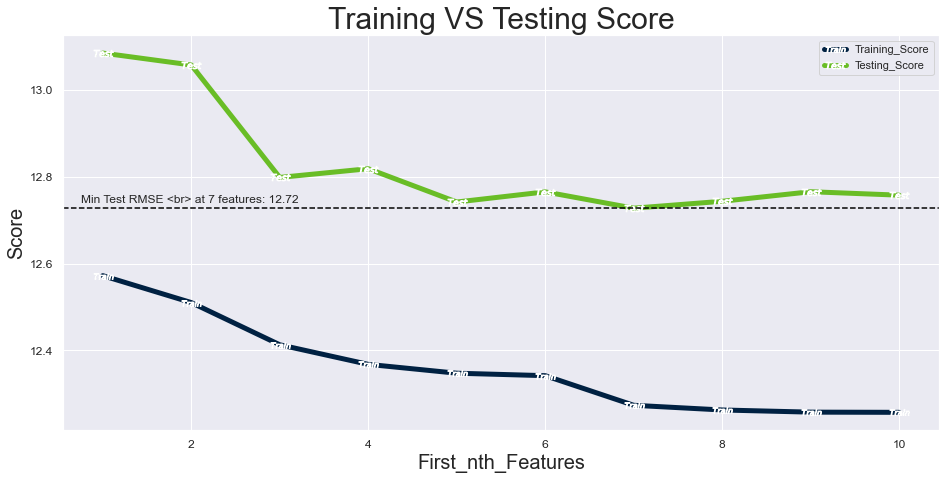

In [10]:
training = sns.lineplot(x=range(1, len(keyssortedbyimportance)+1), y=train_scores,
                        linewidth = 5, color = (0, 0.13, 0.26), label = 'Training_Score', 
                        marker = '$Train$', ms=20, markeredgecolor = 'white', markeredgewidth=1)

testing = sns.lineplot(x=range(1, len(keyssortedbyimportance)+1), y=test_scores,
                       linewidth = 5, color = (0.41, 0.74, 0.15), label = 'Testing_Score',
                       marker = '$Test$', ms=20, markeredgecolor = 'white', markeredgewidth=1)

plt.title('Training VS Testing Score', fontsize=30)
training.set_ylabel('Score', fontsize=20)
training.set_xlabel('First_nth_Features', fontsize=20)
plt.tick_params(axis='both', labelsize=12)
plt.axhline(y = np.min(test_scores), color = 'Black', linestyle = '--')
plt.text(0.75, 12.74, 'Min Test RMSE <br> at 7 features: 12.72')
plt.show()

From the chart above, the test score of RMSE is minimized by using the first seven most essential features: <br> ['instrumentalness',
 'liveness','acousticness', 'danceability', 'loudness', 'tempo', 'duration_ms'] <br> once eight or more features are added, the linear regression model begins to show signs of overfitting - the testing score begins to rise, or degrade as the smaller the RMSE the better at predicting the model, while the training score continues to fall.<br>
 Note: The rise in testing RMSE is not that drastic in this example however, it is the best I could find within my timeframe. This same notebook should be able to do the same task on any other dataframe with only minor adjustments. Also, in previous versions, I preprocessed the data by scaling but decided not to move forward, as it made a minimal overall impact and was beyond the scope of what I intended for this project.